<a href="https://colab.research.google.com/github/robervz22/Proyecto-Final-Series-de-Tiempo-2023/blob/main/VAR_Cointegracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplos sobre modelos VAR y Cointegración

Mostramos unos ejemplos asociados a la presentación extra de *Modelos VAR y Cointegración*


In [ ]:
install.packages('latex2exp')
install.packages('lmtest')

In [ ]:
library(data.table)
library(latex2exp)
library(tidyr)
library(ggplot2)
library(lmtest)
library(dplyr)

In [3]:
# ggplot2 theme
mysize <- 12
mytheme <- theme_bw() + # bw theme
  theme(
    axis.title = element_text(size=mysize),
    axis.text = element_text(size=mysize),
    legend.title = element_text(size=mysize),
    legend.text = element_text(size=mysize),
    plot.title=element_text(hjust=0.5,size=16),
    plot.subtitle=element_text(hjust=0.5,size=14)
    ) # cambiamos algunos valores

In [4]:
# tamanio de los graficos
options(repr.plot.width = 6, repr.plot.height =6) # tamanio de los graficos



---
## Regresión Espuria

### Tendencia comun

A continuación mostramos el efecto de una colinealidad fuerte (tendencias comunes) en un modelo VAR.

In [5]:
set.seed(911)
DW <- c(); R_square <- c(); t_intercept <- c(); t_slope <- c()
n_sim<-500
for (i in 1:n_sim){
  X <- cumsum(rnorm(n=100))
  Y <- cumsum(rnorm(n=100))
  values<-summary(lm(Y~X))
  DW<-c(DW,dwtest(values,alternative = "two.sided")$statistic[[1]])
  R_square<-c(R_square,values$r.squared)
  t_intercept<-c(t_intercept,values$coefficients[,"t value"][[1]])
  t_slope<-c(t_slope,values$coefficients[,"t value"][[2]])
}

Ponemos en una tabla todos los resultados y los manipulamos para una visualización simple

In [6]:
dt_reg_spu <- data.table(x=c(1:n_sim),
                        t_intercept=t_intercept,
                        t_slope=t_slope,
                        R_square=R_square,
                        DW=DW)

dt_reg_spu_melt <- melt(dt_reg_spu,id.vars = "x",
                        measure.vars=c("t_intercept","t_slope","R_square","DW"),
                        variable.name=c("feature"),
                        value.name="value")
dt_reg_spu_melt[,x:=NULL]

Visualización de la regresión espuria

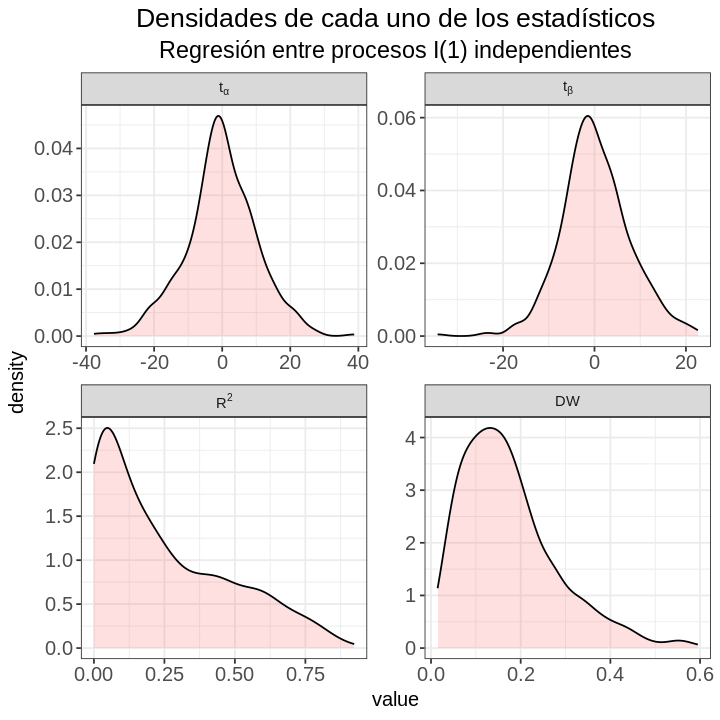

In [7]:
dt_reg_spu_melt_mod <- dt_reg_spu_melt %>%
  mutate(feature = recode(feature,
    "t_intercept" = "t[alpha]",
    "t_slope" = "t[beta]",
    "R_square" = "R^{2}",
    "DW" = "DW"
  ))

ggplot(dt_reg_spu_melt_mod,aes(x=value,group=feature))+
  geom_density(fill="#FF6666",alpha=0.2,)+
  facet_wrap(~feature,scales = "free",labeller = label_parsed)+
  labs(title="Densidades de cada uno de los estadísticos",
  subtitle="Regresión entre procesos I(1) independientes")+mytheme

### Procesos diferenciados

Anteriormente, tenemos que los componentes de la regresion eran $I(1)$, después de quitar la tendencia común con la diferenciación realizamos el mismo ejercicio

In [ ]:
set.seed(911)
DW <- c(); R_square <- c(); t_intercept <- c(); t_slope <- c()
n_sim<-500
for (i in 1:n_sim){
  X <- cumsum(rnorm(n=100))
  X <- diff(X)
  Y <- cumsum(rnorm(n=100))
  Y <- diff(Y)
  values<-summary(lm(Y~X))
  DW<-c(DW,dwtest(values,alternative = "two.sided")$statistic[[1]])
  R_square<-c(R_square,values$r.squared)
  t_intercept<-c(t_intercept,values$coefficients[,"t value"][[1]])
  t_slope<-c(t_slope,values$coefficients[,"t value"][[2]])
}

In [9]:
dt_reg_spu <- data.table(x=c(1:n_sim),
                        t_intercept=t_intercept,
                        t_slope=t_slope,
                        R_square=R_square,
                        DW=DW)

dt_reg_spu_melt <- melt(dt_reg_spu,id.vars = "x",
                        measure.vars=c("t_intercept","t_slope","R_square","DW"),
                        variable.name=c("feature"),
                        value.name="value")
dt_reg_spu_melt[,x:=NULL]

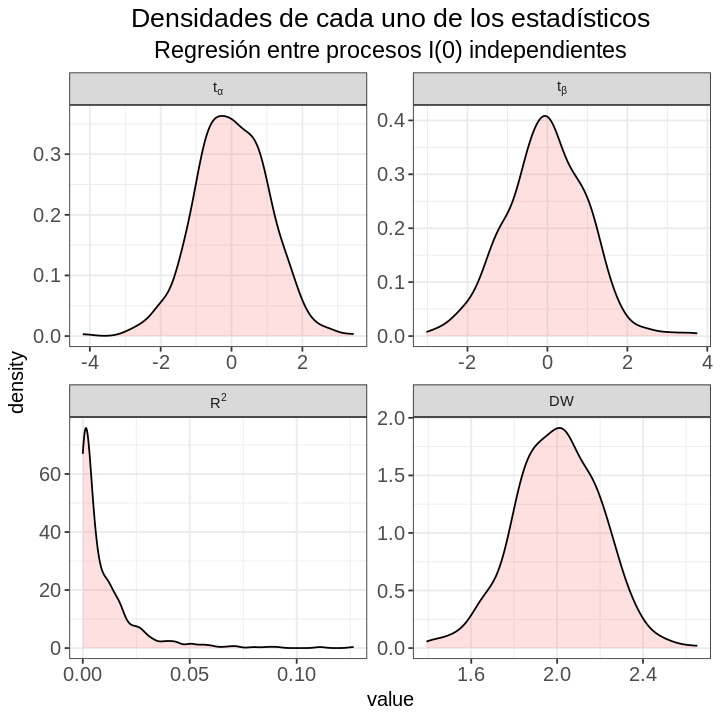

In [10]:
dt_reg_spu_melt_mod <- dt_reg_spu_melt %>%
  mutate(feature = recode(feature,
    "t_intercept" = "t[alpha]",
    "t_slope" = "t[beta]",
    "R_square" = "R^{2}",
    "DW" = "DW"
  ))

ggplot(dt_reg_spu_melt_mod,aes(x=value,group=feature))+
  geom_density(fill="#FF6666",alpha=0.2,)+
  facet_wrap(~feature,scales = "free",labeller = label_parsed)+
  labs(title="Densidades de cada uno de los estadísticos",
  subtitle="Regresión entre procesos I(0) independientes")+mytheme

## Ejemplo de procesos cointegrados y no cointegrados

Obtenido de Maddala 1999.

In [56]:
set.seed(1)
n=100
e_2<-rnorm(n)
v1 <- c(1:100)
v1[1]<-e_2[1]
for (i in 2:100){
    v1[i]=0.8*v1[i-1]+e_2[i]
}
v2 <- cumsum(e_2)

In [57]:
X <- cumsum(rnorm(n=100))
co_Y <- X+v1
Y <- X+v2

Grafica de los procesos

In [ ]:
dt_co_process <- data.table(t=c(1:100),X=X,co_Y=co_Y,Y)

In [89]:
options(repr.plot.width = 10, repr.plot.height =6) # tamanio de los graficos

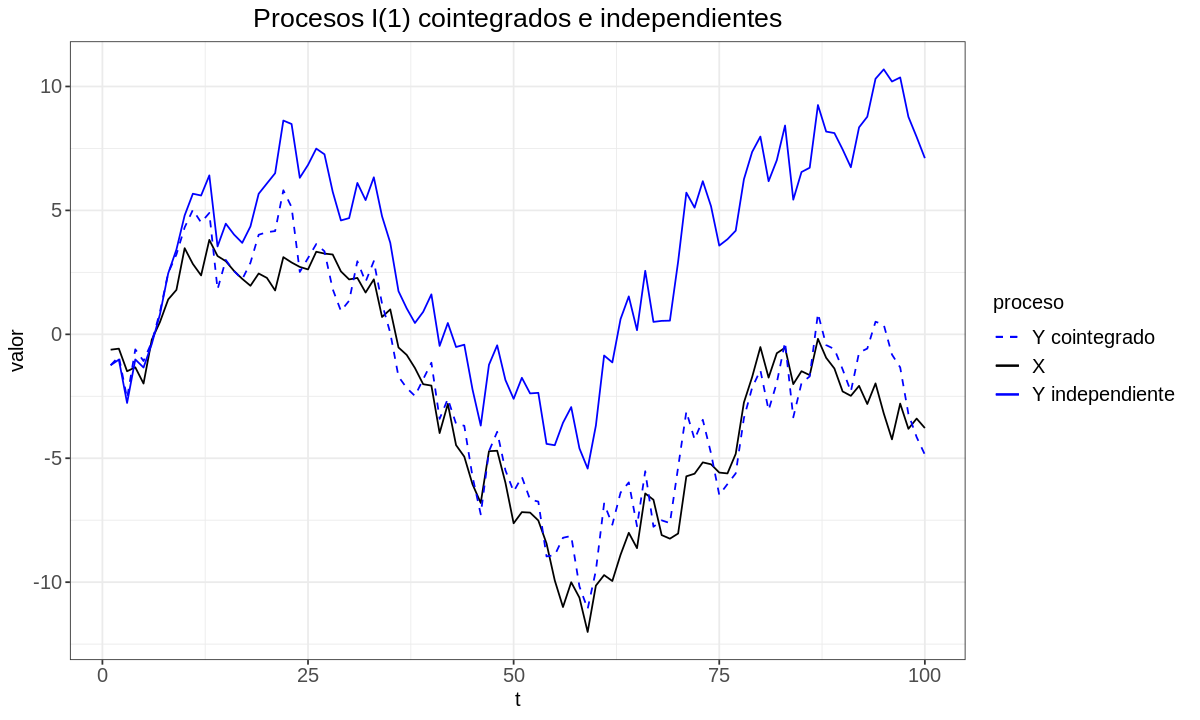

In [92]:
ggplot(dt_co_process,aes(x=t,y=X,color="X"))+geom_line()+
geom_line(aes(y=Y,color="Y"))+
geom_line(aes(y=co_Y,color="co_Y"),linetype="dashed")+
scale_color_manual(name="proceso",values = c('X'='black','Y'='blue','co_Y'='blue'),
labels = c("Y cointegrado","X","Y independiente"))+
guides(linetype=FALSE,
colour = guide_legend(override.aes = list(linetype = c("dashed","solid","solid"))))+
labs(title="Procesos I(1) cointegrados e independientes")+ylab("valor")+
mytheme